# Задание:
1. Выбрать датасет, подходящий для моделирования рекомендательной системы.  Хорошие источники данных: [ods.ai](https://ods.ai/competitions/) и [recsyschallenge.com/2025](https://www.recsyschallenge.com/2025/) (тут можно подставлять любой год, начиная с 2016). Ещё примеры данных: [aicrowd.com](https://www.aicrowd.com/challenges/spotify-million-playlist-dataset-challenge#dataset) и [boosters.pro](https://boosters.pro/championship/rekko_challenge/data). Не рекомендуется брать данные с Kaggle, так как по ним часто уже есть готовый EDA и baseline. Запрещено брать датасет Movielens (любого размера).
2. Сделать разведочный анализ данных (EDA), то есть посчитать статистические показатели, построить визуализации и дать им интерпретацию, подготовить отчёт по качеству данных (пропуски, дубли, выбросы). При необходимости предобработать данные. Сделать выводы.
3. Выбрать минимум три метода формирования рекомендации. Реализовать их. Рекомендуемые методы: MostPop, UserKNN, ItemKNN, SLIM, EASE, ALS. При выборе методов старайтесь брать методы из разных семейств.
4. Выбрать не менее трёх метрик оценки качества рекомендаций. Рассчитать их. Желательно выбирать хотя бы одну метрику, учитывающую качество ранжирования. Желательно выбрать хотя бы одну специфическую для рекомендательных систем метрику (новизна, разнообразие, неожиданность).
5. Сформулировать предложения по улучшению качества рекомендаций. Сделать выводы.
# Критерии оценки:
- Разведочный анализ данных. Оценивается полнота и логика описания датасета. Полнота и логика построения отчёта, качество визуализаций. (10 баллов).
- Метод формирования рекомендаций. Оценивается полнота и логика описания выбранного метода, его обоснованность и релевантность задаче. Оценивается корректность реализации выбранного метода. (14 баллов).
- Метрики качества. Оценивается корректность выбора метрик, полнота и логика их описания, корректность реализации и интерпретации выбранных метрик. (6 баллов).


---
## 0. Импорты, скачивания

In [61]:
import implicit
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib import pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.preprocessing import LabelEncoder
from threadpoolctl import threadpool_limits
from sklearn.model_selection import train_test_split
from tqdm import tqdm

---
## 1. Выбрать датасет, подходящий для моделирования рекомендательной системы.  Хорошие источники данных: [ods.ai](https://ods.ai/competitions/) и [recsyschallenge.com/2025](https://www.recsyschallenge.com/2025/) (тут можно подставлять любой год, начиная с 2016). Ещё примеры данных: [aicrowd.com](https://www.aicrowd.com/challenges/spotify-million-playlist-dataset-challenge#dataset) и [boosters.pro](https://boosters.pro/championship/rekko_challenge/data). Не рекомендуется брать данные с Kaggle, так как по ним часто уже есть готовый EDA и baseline. Запрещено брать датасет Movielens (любого размера).

За основу я взял [spotify-million-playlist-dataset-challenge](https://www.aicrowd.com/challenges/spotify-million-playlist-dataset-challenge#dataset).

Датасет - плейлисты (playlist_id, playlist_name) и песни (track_uri, track_name), пытаемся предсказать, какие песни можно порекомендовать.

Предобработку (json chunks в parquet) я сделал в файле [pre.py](https://github.com/HuTao1Love/DataAnalysis/blob/master/lab-2/pre.py), так как к ЛР это не относится.


In [62]:
df_full = pd.read_parquet("mpd.parquet")
df_full.head(10)

,playlist_id,playlist_name,modified_at,track_uri,track_name,artist_name,album_name,pos,duration_ms
0,0,Throwbacks,1493424000,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,Lose Control (feat. Ciara & Fat Man Scoop),Missy Elliott,The Cookbook,0,226863
1,0,Throwbacks,1493424000,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,Toxic,Britney Spears,In The Zone,1,198800
2,0,Throwbacks,1493424000,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,Crazy In Love,Beyoncé,Dangerously In Love (Alben für die Ewigkeit),2,235933
3,0,Throwbacks,1493424000,spotify:track:1AWQoqb9bSvzTjaLralEkT,Rock Your Body,Justin Timberlake,Justified,3,267266
4,0,Throwbacks,1493424000,spotify:track:1lzr43nnXAijIGYnCT8M8H,It Wasn't Me,Shaggy,Hot Shot,4,227600
5,0,Throwbacks,1493424000,spotify:track:0XUfyU2QviPAs6bxSpXYG4,Yeah!,Usher,Confessions,5,250373
6,0,Throwbacks,1493424000,spotify:track:68vgtRHr7iZHpzGpon6Jlo,My Boo,Usher,Confessions,6,223440
7,0,Throwbacks,1493424000,spotify:track:3BxWKCI06eQ5Od8TY2JBeA,Buttons,The Pussycat Dolls,PCD,7,225560
8,0,Throwbacks,1493424000,spotify:track:7H6ev70Weq6DdpZyyTmUXk,Say My Name,Destiny's Child,The Writing's On The Wall,8,271333
9,0,Throwbacks,1493424000,spotify:track:2PpruBYCo4H7WOBJ7Q2EwM,Hey Ya! - Radio Mix / Club Mix,OutKast,Speakerboxxx/The Love Below,9,235213


In [63]:
sampled_playlists = (
    df_full["playlist_id"]
    .drop_duplicates()
    .sample(frac=0.1, random_state=42)
)

df_sampled = df_full[df_full["playlist_id"].isin(sampled_playlists)].reset_index(drop=True)

train_parts = []
test_parts = []

for pid, group in df_sampled.groupby("playlist_id"):
    if len(group) < 2: continue
    train, test = train_test_split(group, test_size=0.2, random_state=42)
    train_parts.append(train)
    test_parts.append(test)

df = pd.concat(train_parts).reset_index(drop=True)
test_df = pd.concat(test_parts).reset_index(drop=True)

df_full_len = len(df_full)
del df_full

print(f"Train size: {len(df)} rows, Test size: {len(test_df)} rows, unique playlists: {df['playlist_id'].nunique()}")


Train size: 5239165 rows, Test size: 1359463 rows, unique playlists: 100000


---
## 2. Сделать разведочный анализ данных (EDA), то есть посчитать статистические показатели, построить визуализации и дать им интерпретацию, подготовить отчёт по качеству данных (пропуски, дубли, выбросы). При необходимости предобработать данные. Сделать выводы.


In [64]:
print(f"Full DF size: {df_full_len:,}")
print(f"DF sample size: {len(df):,}")
print(f"Unique playlist count: {df['playlist_id'].nunique():,}")
print(f"Unique track count: {df['track_uri'].nunique():,}")
print(f"Unique artist count: {df['artist_name'].nunique():,}")
print(f"Duplicates in playlists: {df.duplicated(subset=["playlist_id", "track_uri"]).sum()}")

print("-" * 30)
print(f"Skips:\n{df.isna().sum()}")

print("-" * 30)
q_low = df["duration_ms"].quantile(0.01)
q_high = df["duration_ms"].quantile(0.99)

below = (df["duration_ms"] < q_low).sum()
above = (df["duration_ms"] > q_high).sum()

print(f"1st percentile [below - {below}]: {q_low/1000:.1f} sec")
print(f"99th percentile [above - {above}]: {q_high/1000:.1f} sec")

df.describe()

Full DF size: 66,346,428
DF sample size: 5,239,165
Unique playlist count: 100,000
Unique track count: 602,585
Unique artist count: 98,870
Duplicates in playlists: 56551
------------------------------
Skips:
playlist_id      0
playlist_name    0
modified_at      0
track_uri        0
track_name       0
artist_name      0
album_name       0
pos              0
duration_ms      0
dtype: int64
------------------------------
1st percentile [below - 52388]: 108.9 sec
99th percentile [above - 52341]: 465.3 sec


,playlist_id,modified_at,pos,duration_ms
count,5.239165e+06,5.239165e+06,5.239165e+06,5.239165e+06
mean,4.999509e+05,1.480236e+09,5.444510e+01,2.346766e+05
std,2.892761e+05,3.546906e+07,4.792546e+01,7.309417e+04
min,0.000000e+00,1.304208e+09,0.000000e+00,0.000000e+00
25%,2.480230e+05,1.465344e+09,1.700000e+01,1.983730e+05
50%,5.000540e+05,1.495411e+09,4.000000e+01,2.250530e+05
75%,7.503680e+05,1.507075e+09,7.900000e+01,2.592000e+05
max,9.999980e+05,1.509494e+09,2.490000e+02,1.043547e+07


In [65]:
df.sort_values(by="duration_ms", ascending=False).head(5)

,playlist_id,playlist_name,modified_at,track_uri,track_name,artist_name,album_name,pos,duration_ms
859984,163612,kaitlyn,1508716800,spotify:track:3uMIfxV8q5tPTWzJh8s6Mk,One Love Manchester - Live from One Love Manch...,Various Artists,One Love Manchester,141,10435467
746881,141782,yasssss,1503878400,spotify:track:7ju02bkmmEBTazvhtOvURa,Asking All Dem Questions ft. Emanuel & Philip ...,The 85 South Show,Asking All Dem Questions ft. Emanuel & Philip ...,123,9811736
1772271,336904,Monstercat,1507593600,spotify:track:4mjgNE8R31AzxWfPNGtVMf,Best of 2015 (Album Mix),Monstercat,Monstercat: Best of 2015,88,9158194
1772218,336904,Monstercat,1507593600,spotify:track:5CmMyiq4um2aFhiLZ1rPWo,Best of 2016 (Album Mix),Monstercat,Monstercat - Best of 2016,97,9146416
5102056,974397,Sarah :),1442880000,spotify:track:26nKuCDkXhCdQHtpbQyUpo,Surah Al Baqara,Sheikh Mishary Alafasy,The complete Holy Quran,84,7575928


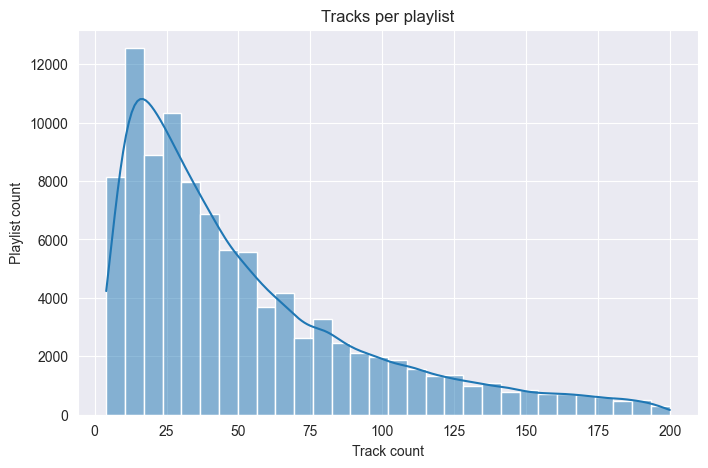

In [66]:
tracks_per_playlist = df.groupby("playlist_id")["track_uri"].count()
plt.figure(figsize=(8, 5))
sns.histplot(tracks_per_playlist, bins=30, kde=True)
plt.title("Tracks per playlist")
plt.xlabel("Track count")
plt.ylabel("Playlist count")
plt.show()

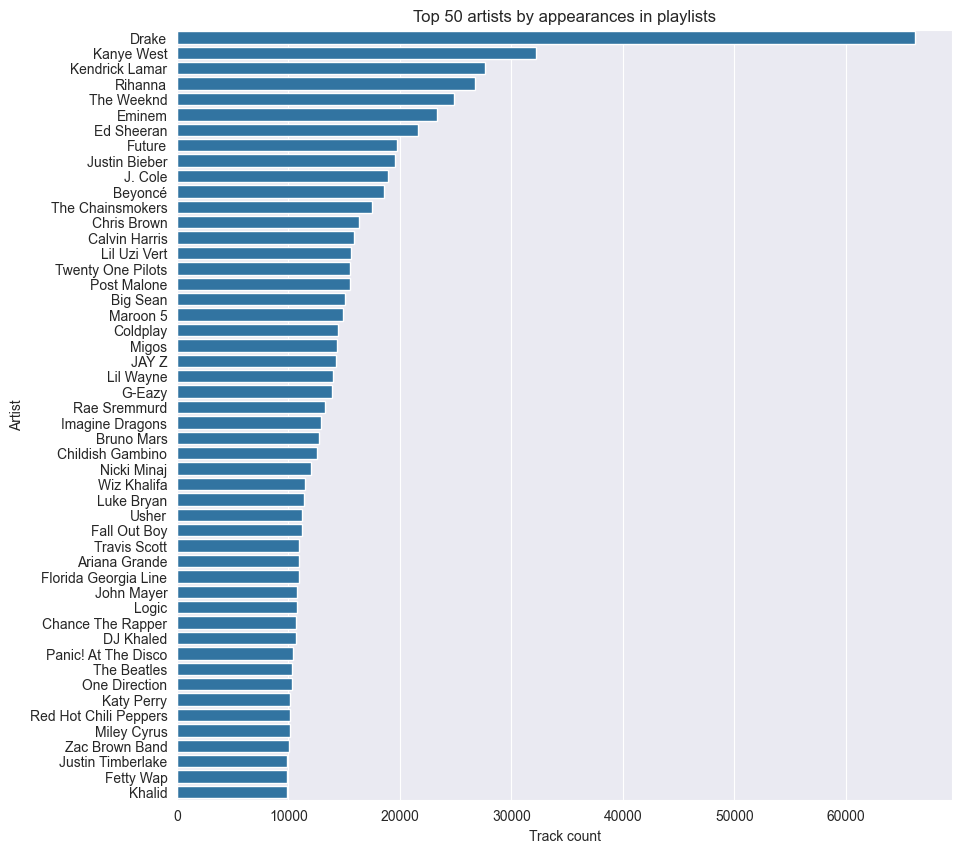

In [67]:
top_artists = df["artist_name"].value_counts().head(50)
plt.figure(figsize=(10, 10))
sns.barplot(x=top_artists.values, y=top_artists.index)
plt.title("Top 50 artists by appearances in playlists")
plt.xlabel("Track count")
plt.ylabel("Artist")
plt.show()

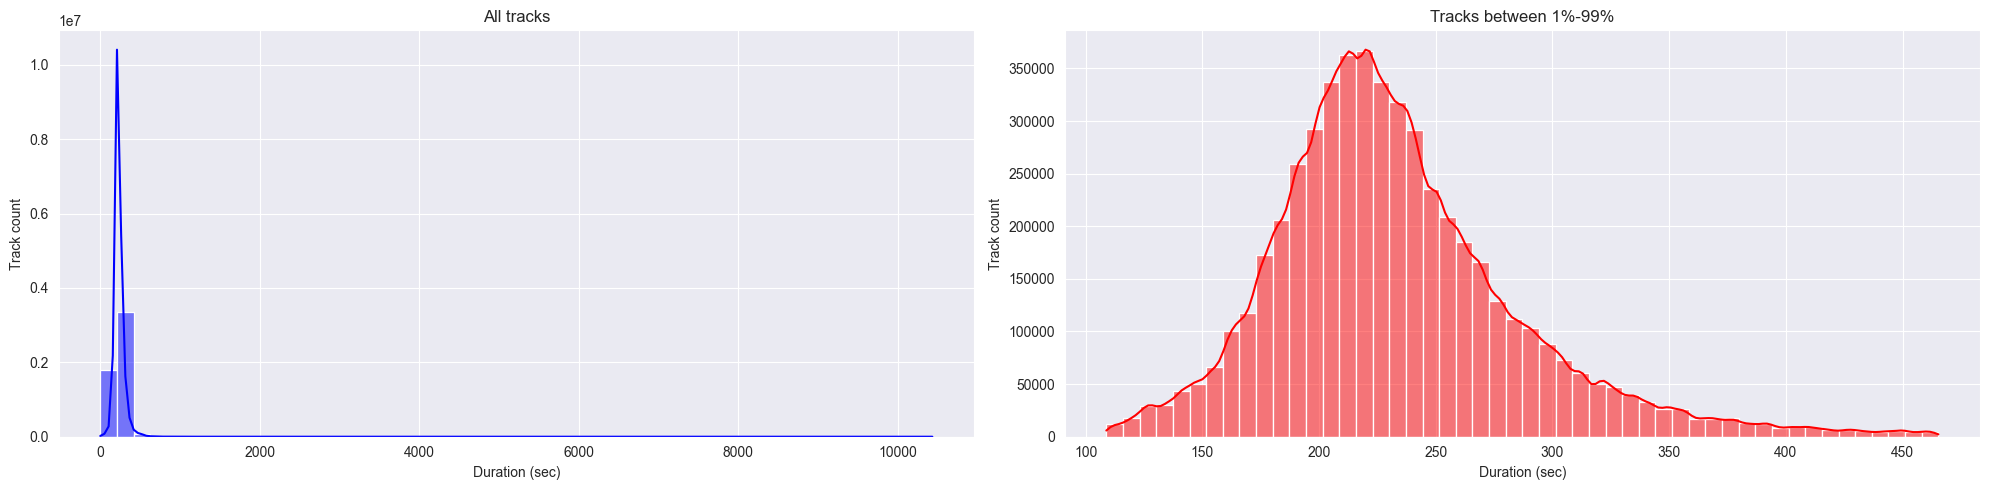

In [68]:
durations_filtered = df.loc[
    (df["duration_ms"] >= q_low) &
    (df["duration_ms"] <= q_high),
    "duration_ms"
]

fig, axes = plt.subplots(1, 2, figsize=(20, 5))

sns.histplot(df["duration_ms"] / 1000, bins=50, kde=True, ax=axes[0], color="blue")
axes[0].set_title("All tracks")
axes[0].set_xlabel("Duration (sec)")
axes[0].set_ylabel("Track count")

sns.histplot(durations_filtered / 1000, bins=50, kde=True, ax=axes[1], color="red")
axes[1].set_title("Tracks between 1%-99%")
axes[1].set_xlabel("Duration (sec)")
axes[1].set_ylabel("Track count")

plt.tight_layout()
plt.show()

---
## 3. Выбрать минимум три метода формирования рекомендации. Реализовать их. Рекомендуемые методы: MostPop, UserKNN, ItemKNN, SLIM, EASE, ALS. При выборе методов старайтесь брать методы из разных семейств.


In [69]:
class Recommender:
    def __init__(self, rtr: csr_matrix):
        self.rtr = rtr

    def recommend(self, playlist_id: int, n: int = 10) -> np.ndarray:
        raise NotImplementedError

### MostPop
> Рекомендует самые популярные песни среди всех, не учитывает плейлист

In [70]:
class MostPopRecommender(Recommender):
    def fit(self):
        self.track_popularity = np.asarray(self.rtr.sum(axis=0)).ravel()

    def recommend(self, playlist_id: int, n: int = 10) -> np.ndarray:
        seen = set(self.rtr[playlist_id].indices)
        rec = [i for i in np.argsort(-self.track_popularity) if i not in seen][:n]
        return np.array(rec)

### ItemKNN
> Метод на основе ближайших соседей. Берет максимально похожие

In [71]:
# at first, i've tried from implicit, but got error `File implicit/_nearest_neighbours.pyx:134, in implicit._nearest_neighbours.all_pairs_knn() ValueError: Buffer dtype mismatch, expected 'long' but got 'long long``
class ItemKNNRecommender(Recommender):
    def __init__(self, rtr, k_neighbors=200):
        super().__init__(rtr)
        self.k_neighbors = k_neighbors
        self.similarity = None

    def fit(self):
        self.similarity = cosine_similarity(self.rtr.T, dense_output=False)

    def recommend(self, playlist_id, n=10):
        existing = set(self.rtr[playlist_id].indices)
        scores = self.similarity[:, self.rtr[playlist_id].indices].sum(axis=1)
        scores = np.array(scores).ravel()
        scores[list(existing)] = -np.inf
        top_idx = np.argpartition(-scores, n)[:n]
        return top_idx[np.argsort(-scores[top_idx])]

### ALS
> Строит векторы для плейлистов и песен и предсказывает вероятность "взаимодействия"

In [72]:
class ALSRecommender(Recommender):
    def __init__(self, rtr: csr_matrix, factors=128, reg=0.01, iterations=50):
        super().__init__(rtr)
        self.model = implicit.als.AlternatingLeastSquares(
            factors=factors, regularization=reg, iterations=iterations, random_state=42
        )
        self.mostPop = MostPopRecommender(self.rtr)

    def fit(self):
        with threadpool_limits(limits=1, user_api='blas'):
            self.model.fit(self.rtr.tocsr(), show_progress=False)
        self.mostPop.fit()

    def recommend(self, playlist_id: int, n: int = 10) -> np.ndarray:
        if self.rtr[playlist_id].nnz == 0: return self.mostPop.recommend(playlist_id, n)

        recs, _ = self.model.recommend(
            userid=playlist_id,
            user_items=self.rtr[playlist_id],
            N=n,
            filter_already_liked_items=True,
            recalculate_user=True
        )

        return np.array(recs)

### Пример использования

In [73]:
def to_csr(df: pd.DataFrame) -> tuple[csr_matrix, LabelEncoder, LabelEncoder]:
    playlist_enc = LabelEncoder()
    track_enc = LabelEncoder()

    playlist_ids = playlist_enc.fit_transform(df["playlist_id"]).astype(np.long)
    track_ids = track_enc.fit_transform(df["track_uri"]).astype(np.long)

    data = np.ones(len(df), dtype=np.float32)
    return (
        csr_matrix(
            (data, (playlist_ids, track_ids)),
            shape=(len(playlist_enc.classes_), len(track_enc.classes_))),
        playlist_enc,
        track_enc
    )

rtr, playlist_enc, track_enc = to_csr(df)
test_rtr, _, _ = to_csr(test_df)

recommenders = {
    "MostPop": MostPopRecommender(rtr),
    "ItemKNN": ItemKNNRecommender(rtr),
    "ALS": ALSRecommender(rtr),
}

for name, recommender in recommenders.items():
    recommender.fit()

playlists_with_tracks = np.where(rtr.getnnz(axis=1) > 0)[0]
probe_playlists = np.random.choice(playlists_with_tracks, size=min(5, len(playlists_with_tracks)), replace=False)
track_info = df[['track_uri', 'track_name', 'artist_name']].drop_duplicates().set_index('track_uri')

for pid in probe_playlists:
    print(f"Playlist ID: {pid}")

    track_ids_in_playlist = rtr[pid].indices[:10]
    track_uris_in_playlist = track_enc.inverse_transform(track_ids_in_playlist)
    print("Tracks in playlist [first 10]:")
    for uri in track_uris_in_playlist:
        print(f"  - {track_info.at[uri, 'track_name']} — {track_info.at[uri, 'artist_name']}")

    # рекомендации
    for name, recommender in recommenders.items():
        rec_ids = recommender.recommend(pid)
        rec_uris = track_enc.inverse_transform(rec_ids)
        print(f"\nRecommendations by {name}:")
        for uri in rec_uris:
            print(f"  - {track_info.at[uri, 'track_name']} — {track_info.at[uri, 'artist_name']}")

    print("\n" + "-"*50 + "\n")


Playlist ID: 55742
Tracks in playlist [first 10]:
  - Front Row — Alanis Morissette
  - On The Run (Live At The Empire Pool, Wembley, London 1974) - 2011 Remastered Version — Pink Floyd
  - Time (Live At The Empire Pool, Wembley, London 1974) - 2011 Remastered Version — Pink Floyd
  - I Took A Pill In Ibiza - Seeb Remix — Mike Posner
  - Slip — Elliot Moss
  - Be Careful — Patty Griffin
  - These Words — Natasha Bedingfield
  - Hollow Moon (Bad Wolf) — AWOLNATION
  - Ironic - 2015 Remastered — Alanis Morissette
  - Ultralight Beam — Kanye West

Recommendations by MostPop:
  - HUMBLE. — Kendrick Lamar
  - One Dance — Drake
  - Broccoli (feat. Lil Yachty) — DRAM
  - Closer — The Chainsmokers
  - Congratulations — Post Malone
  - iSpy (feat. Lil Yachty) — KYLE
  - XO TOUR Llif3 — Lil Uzi Vert
  - Caroline — Aminé
  - Bad and Boujee (feat. Lil Uzi Vert) — Migos
  - Location — Khalid

Recommendations by ItemKNN:
  - Any Colour You Like (Live At The Empire Pool, Wembley, London 1974) - 2011 

---
## 4. Выбрать не менее трёх метрик оценки качества рекомендаций. Рассчитать их. Желательно выбирать хотя бы одну метрику, учитывающую качество ранжирования. Желательно выбрать хотя бы одну специфическую для рекомендательных систем метрику (новизна, разнообразие, неожиданность).


In [74]:
class Metric:
    def __init__(self, k=10):
        self.k = k

    def compute(self, recommended, relevant):
        raise NotImplementedError

### Precision@K
> Показывает, какая доля из первых K предложенных рекомендаций действительно релевантна пользователю.

In [75]:
class Precision(Metric):
    def compute(self, recommended, relevant):
        if not relevant:
            return 0.0
        recommended_k = recommended[:self.k]
        return len(set(recommended_k) & relevant) / self.k

### Recall@K (Полнота на K рекомендаций)

> Показывает, какую долю всех релевантных элементов для пользователя мы смогли включить в первые K рекомендаций.

In [76]:
class Recall(Metric):
    def compute(self, recommended, relevant):
        if not relevant:
            return 0.0
        recommended_k = recommended[:self.k]
        return len(set(recommended_k) & relevant) / len(relevant)

### NDCG@K (Normalized Discounted Cumulative Gain на K рекомендаций)

> Оценивает качество рекомендаций с учётом порядка следования: чем выше релевантность элемента в списке, тем лучше.

In [77]:
class NDCG(Metric):
    def compute(self, recommended, relevant):
        if not relevant:
            return 0.0
        dcg, idcg = 0.0, 0.0
        for idx, item in enumerate(recommended[:self.k], start=1):
            if item in relevant:
                dcg += 1 / np.log2(idx + 1)
        for idx in range(1, min(len(relevant), self.k) + 1):
            idcg += 1 / np.log2(idx + 1)
        return dcg / idcg if idcg > 0 else 0.0

---
### Оценим
P.S. recommenders уже обучены

In [ ]:
def evaluate(recommender: Recommender, metric: Metric, Rval: csr_matrix, n_users_eval: int = 1000):
    np.random.seed(42)
    playlist_ids = np.random.choice(
        Rval.nonzero()[0],
        size=min(n_users_eval, Rval.shape[0]),
        replace=False
    )

    values = []
    for playlist_id in playlist_ids:
        relevant_items = set(Rval[playlist_id].indices)
        if not relevant_items:
            continue
        recommended_items = recommender.recommend(playlist_id, n=metric.k)
        values.append(metric.compute(recommended_items, relevant_items))

    return np.mean(values) if values else 0.0


metrics = dict(
    precision = Precision(k=10),
    recall = Recall(k=10),
    ndcg = NDCG(k=10)
)

results = []

tasks = [(name, recommender, metric_name, metric)
         for name, recommender in recommenders.items()
         for metric_name, metric in metrics.items()]

with tqdm(total=len(tasks)) as pbar:
    for name, recommender, metric_name, metric in tasks:
        pbar.set_description(f"{name} x {metric_name}")
        score = evaluate(recommender, metric, test_rtr)

        row = next((r for r in results if r["Recommender"] == name), None)
        if row is None:
            row = {"Recommender": name}
            results.append(row)

        row[metric_name] = score
        pbar.update(1)

pd.DataFrame(results)

ItemKNN x precision:  33%|███▎      | 3/9 [01:42<03:29, 34.86s/it]

---
## 5. Сформулировать предложения по улучшению качества рекомендаций. Сделать выводы.

На основе рассчитанных метрик (precision, recall, ndcg) можно сделать вывод, что качество рекомендаций находится на низком уровне. Это в первую очередь связано с разреженностью данных (много уникальных треков и очень мало пересечений между плейлистами).

Для улучшения качества рекомендаций можно попробовать:
1. Использовать больше 2% данных
2. "Поиграться" с гиперпараметрами
3. Попробовать добавить контентные признаки (жанр, артист)
4. Использовать более сложные модели